<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# How to bin detector pair angles?

Author: Patricia Schuster  
Date: Summer 2017  
Institution: UM NERS  
Email: pfschus@umich.edu  

What is the best way to bin detector pair angles? Build some tools.

In [2]:
# Import packages
import os.path
import time
import numpy as np
np.set_printoptions(threshold=np.nan) # print entire matrices
import sys
import inspect
import matplotlib.pyplot as plt
import scipy.io as sio
from tqdm import *
import pandas as pd

In [4]:
import seaborn as sns
sns.set_palette('hls')
sns.set_style(style='white')

In [11]:
sys.path.append('../scripts/')
import bicorr as bicorr
import bicorr_plot as bicorr_plot

In [6]:
%load_ext autoreload
%autoreload 2

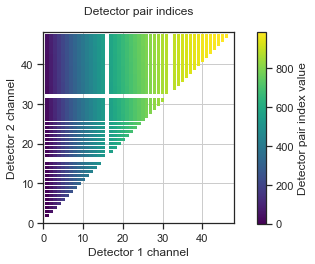

<Figure size 432x288 with 0 Axes>

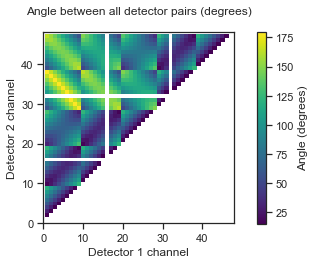

<Figure size 432x288 with 0 Axes>

In [7]:
# Load det_df
det_df = bicorr.load_det_df(plot_flag=True)

# Look at the distribution of angles

In [9]:
det_df.head()

,d1,d2,d1d2,angle
0,1,2,102,15.0
1,1,3,103,30.0
2,1,4,104,45.0
3,1,5,105,60.0
4,1,6,106,75.0


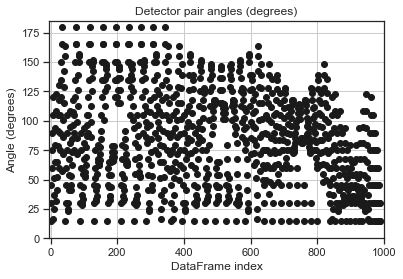

In [8]:
plt.scatter(det_df.index,det_df['angle'].values,color='k')
plt.xlabel('DataFrame index')
plt.ylabel('Angle (degrees)')
plt.title('Detector pair angles (degrees)')
plt.xlim([-5,1000])
plt.ylim([0,185])
plt.grid()
plt.savefig('../fig/angle_vs_pair.png')
plt.show()

## Histogram with equal bin width

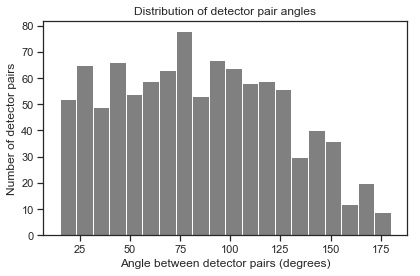

In [14]:
plt.hist(det_df['angle'],20,color='gray')
plt.xlabel('Angle between detector pairs (degrees)')
plt.ylabel('Number of detector pairs')
plt.title('Distribution of detector pair angles')
bicorr_plot.save_fig_to_folder(fig_filename='hist_angles',fig_folder='../fig')
plt.show()

## Histogram with non-uniform bin widths

In [12]:
bin_edges = np.array([14.0,20.0,30.0,40.0,50.0,59.0,61.0,65.0,75.0,85.0,95.0, 105.0,115.0,125.0, 133.0,139.0,145.0,149.0,153.0,160.0,170.0,180.0])
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

In [13]:
hist = np.histogram(det_df['angle'].values, bins = bin_edges)[0]

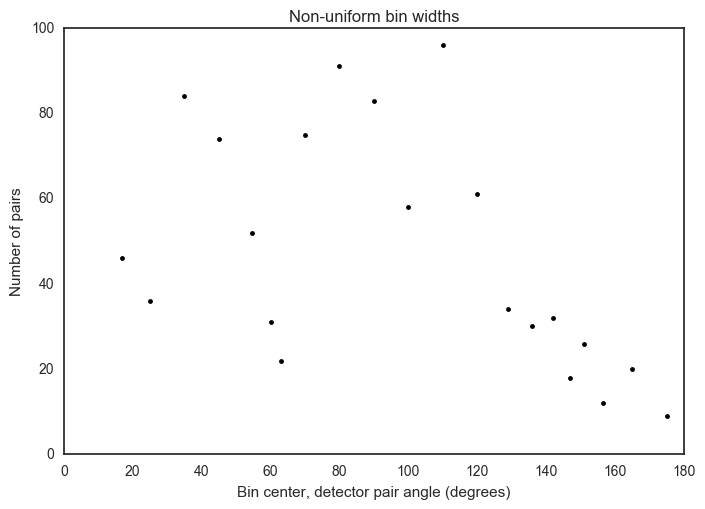

In [14]:
plt.plot(bin_centers, hist,'.k')
plt.xlabel('Bin center, detector pair angle (degrees)')
plt.ylabel('Number of pairs')
plt.title('Non-uniform bin widths')
plt.show()

## Unique angles, investigate rounding effects

How many unique angles are there?

In [15]:
[unique, unique_counts] = np.unique(det_df['angle'].values,return_counts=True)
print(unique.shape)

(137,)


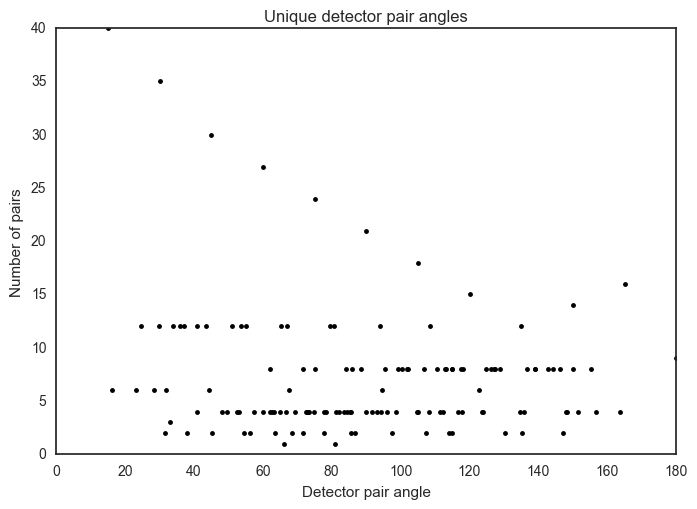

In [16]:
plt.plot(unique,unique_counts,'.k')
plt.xlabel('Detector pair angle')
plt.ylabel('Number of pairs')
plt.title('Unique detector pair angles')
plt.savefig('../fig/angles_unique.png')
plt.show()

Round to the nearest .1 degrees. This collapses 6 bins... not very many.

(131,)


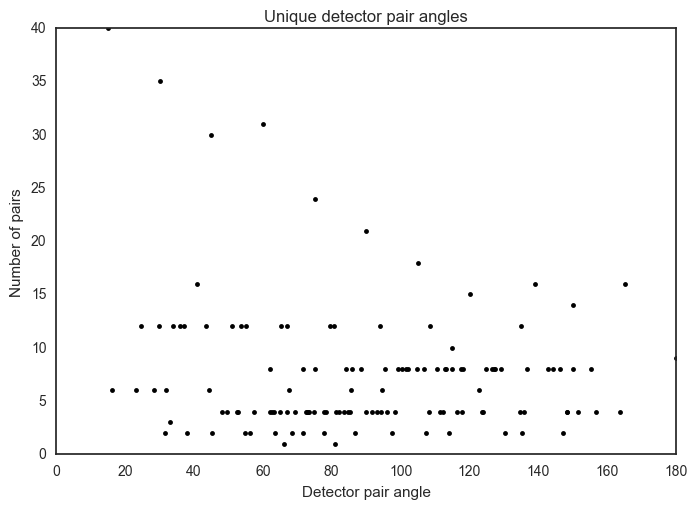

In [17]:
[unique, unique_counts] = np.unique(np.round(det_df['angle'].values,1),return_counts=True)
print(unique.shape)

plt.plot(unique,unique_counts,'.k')
plt.xlabel('Detector pair angle')
plt.ylabel('Number of pairs')
plt.title('Unique detector pair angles')
plt.show()

Try rounding it to the nearest degree. This collapses the data a lot to only 90 unique angles.

(90,)


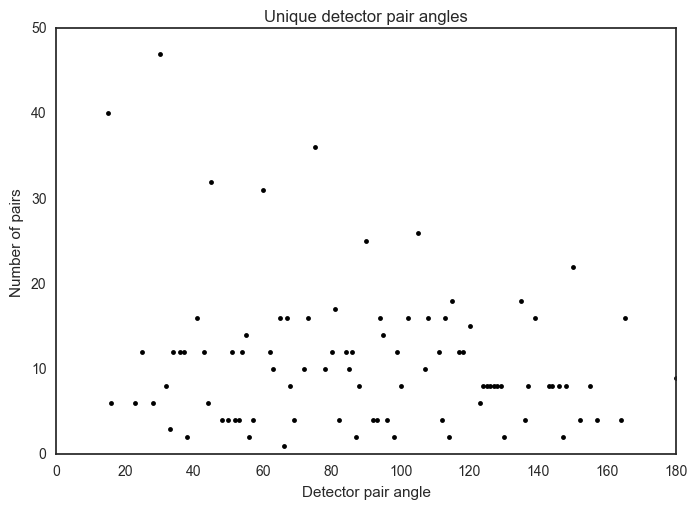

In [18]:
[unique, unique_counts] = np.unique(np.round(det_df['angle'].values,0),return_counts=True)
print(unique.shape)

plt.plot(unique,unique_counts,'.k')
plt.xlabel('Detector pair angle')
plt.ylabel('Number of pairs')
plt.title('Unique detector pair angles')
plt.savefig('../fig/angles_unique_round.png')
plt.show()

# Fill 'bin' column in DataFrame

Into which bin in the histogram does each detector pair fall?

Make use of the numpy function `np.digitize`, <https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.digitize.html>.

In [19]:
angle_hist, angle_bin_edges = np.histogram(det_df['angle'].values,20)
print(angle_bin_edges)

[  15.     23.25   31.5    39.75   48.     56.25   64.5    72.75   81.
   89.25   97.5   105.75  114.    122.25  130.5   138.75  147.    155.25
  163.5   171.75  180.  ]


In [20]:
for pair in det_df.index:
    det_df.loc[pair,'bin'] = np.digitize(det_df.loc[pair,'angle'],angle_bin_edges)

In [21]:
det_df.head()

,d1,d2,d1d2,angle,bin
0,1,2,102,15.0,1.0
1,1,3,103,30.0,2.0
2,1,4,104,45.0,4.0
3,1,5,105,60.0,6.0
4,1,6,106,75.0,8.0


# Select events within a given angle range

I will write a function `generate_pair_is` which will take a bin number or an angle range. If a bin number, then the bin column in `det_df` must already be filled.

## By bin number

Store the indices of pairs at a given angle range as `pair_is`.

In [22]:
i_bin = 19
det_df[det_df['bin']==i_bin]

pair_is = det_df[det_df['bin']==i_bin].index.values
print(len(pair_is), 'pairs bin', i_bin, 'at indices', pair_is)
det_df.loc[pair_is]

20 pairs bin 19 at indices [ 33  43  75  77 116 118 156 158 195 197 233 235 270 272 306 308 343 351
 385 621]


,d1,d2,d1d2,angle,bin
33,1,37,137,165.000000,19.0
43,1,47,147,163.671923,19.0
75,2,36,236,165.000000,19.0
77,2,38,238,165.000000,19.0
116,3,35,335,165.000000,19.0
118,3,37,337,165.000000,19.0
156,4,34,434,165.000000,19.0
158,4,36,436,165.000000,19.0
195,5,33,533,165.000000,19.0
197,5,35,535,165.000000,19.0


In [23]:
mean_angle = np.mean(det_df.loc[pair_is]['angle'].values)
print(mean_angle)

164.734384684


In [24]:
[unique_bin, unique_counts_bin] = np.unique(det_df.loc[pair_is]['angle'],return_counts=True)
print(unique_bin)
print(unique_counts_bin)

[ 163.67192342  165.        ]
[ 4 16]


## By angle range

Provide `th_min` and `th_max`. Write the function `bicorr.generate_pair_is_th_range`. Quite a lengthy function name but we'll go with it. 

In [25]:
th_min = 20.0
th_max = 25.0

ind_mask = (det_df['angle'] > th_min) & (det_df['angle'] <= th_max) # Includes upper bin edge
ind = det_df.index[ind_mask].values

print(ind)

[  9  51  52 295 296 331 369 402 403 592 593 619 846 861 862 943 944 952]


## Functionalize this in a general method

In [26]:
bicorr.generate_pair_is(det_df,th_min = 0,th_max=20)

array([  0,   8,  44,  87, 129, 170, 210, 249, 287, 332, 360, 368, 395,
       429, 462, 494, 525, 555, 584, 620, 639, 665, 690, 714, 737, 759,
       780, 800, 837, 845, 854, 870, 885, 899, 912, 924, 935, 953, 954,
       962, 969, 975, 980, 984, 987, 989], dtype=int64)

In [27]:
det_df.loc[bicorr.generate_pair_is(det_df,i_bin = 18)]

,d1,d2,d1d2,angle,bin
42,1,46,146,155.352029,18.0
85,2,46,246,156.829098,18.0
86,2,47,247,155.352029,18.0
315,8,39,839,155.352029,18.0
316,8,40,840,156.829098,18.0
352,9,40,940,155.352029,18.0
384,10,37,1037,155.352029,18.0
418,11,37,1137,156.829098,18.0
419,11,38,1138,155.352029,18.0
594,18,29,1829,155.352029,18.0


# Loop through each angle bin

Restart the kernel, load `det_df` with empty `bin` column, and begin.

**Specify angle bin edges**

In [28]:
# Load det_df
det_df = bicorr.load_det_df()

In [29]:
det_df.head()

,d1,d2,d1d2,angle
0,1,2,102,15.0
1,1,3,103,30.0
2,1,4,104,45.0
3,1,5,105,60.0
4,1,6,106,75.0


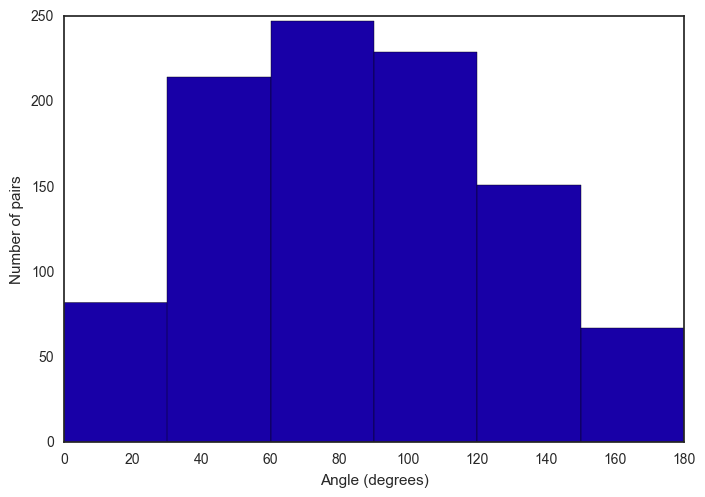

In [30]:
angle_hist, angle_bin_edges = plt.hist(det_df['angle'].values,bins=np.arange(0,181,30))[0:2]
plt.xlabel('Angle (degrees)')
plt.ylabel('Number of pairs')
plt.show()

In [31]:
angle_bin_edges

array([  0,  30,  60,  90, 120, 150, 180])

** Fill `bin` column **

In [32]:
for pair in det_df.index:
    det_df.loc[pair,'bin'] = np.digitize(det_df.loc[pair,'angle'],angle_bin_edges,right=True)

In [33]:
det_df.head()

,d1,d2,d1d2,angle,bin
0,1,2,102,15.0,1.0
1,1,3,103,30.0,1.0
2,1,4,104,45.0,2.0
3,1,5,105,60.0,2.0
4,1,6,106,75.0,3.0


** Loop through each bin and generate, plot `pair_is` **

Bin  1


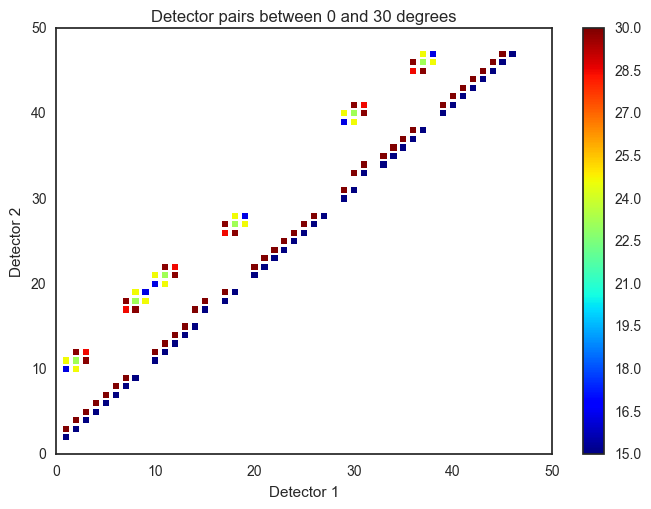

Bin  2


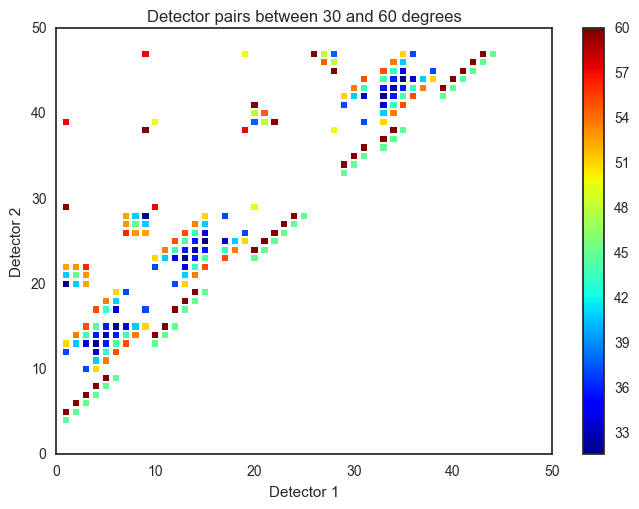

Bin  3


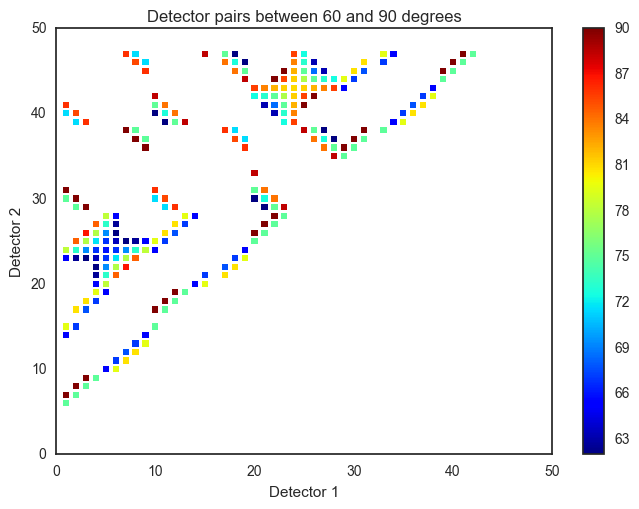

Bin  4


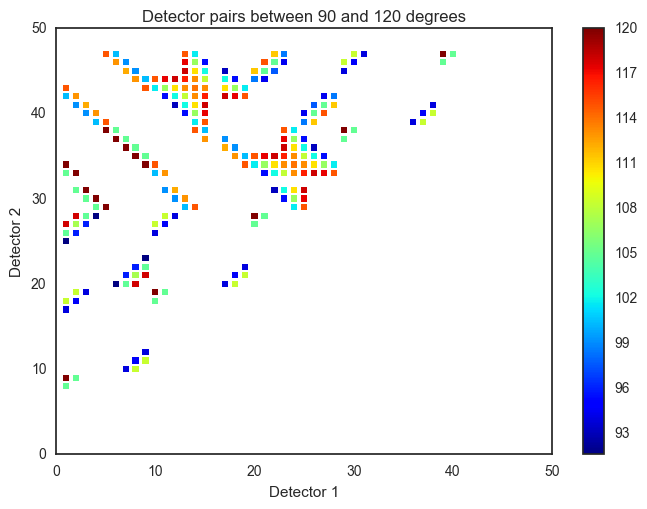

Bin  5


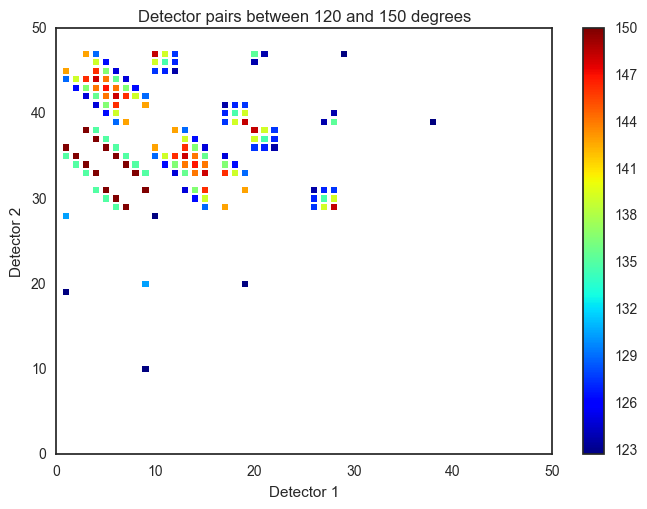

Bin  6


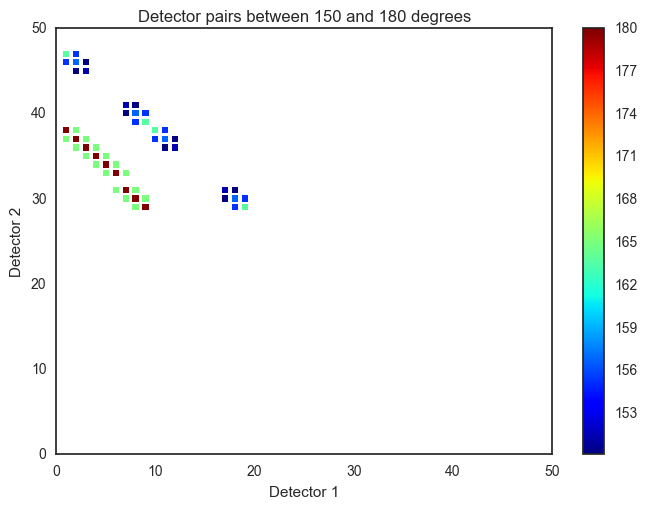

990


In [34]:
count = 0
for i_bin in np.arange(1,len(angle_bin_edges)):
    print('Bin ', i_bin)
    pair_is = bicorr.generate_pair_is(det_df, i_bin = i_bin)
    count += len(pair_is)
    
    plt.scatter(det_df.loc[pair_is]['d1'],det_df.loc[pair_is]['d2'],c=list(det_df.loc[pair_is]['angle']),s=20,marker='s',edgecolor='none',cmap='jet')
    plt.colorbar()
    plt.xlim([0,50])
    plt.ylim([0,50])
    plt.xlabel('Detector 1')
    plt.ylabel('Detector 2')
    plt.title('Detector pairs between {} and {} degrees'.format(angle_bin_edges[i_bin-1],angle_bin_edges[i_bin]))
    plt.show()
print(count)